In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt

from utils.df_loader import get_loading_fn
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocess_df
from utils.models import  load_three_models
from dtreeviz.trees import *
import PIL
import pydotplus
from six import StringIO
from sklearn.tree import export_graphviz
from utils.evaluation import prepare_evaluation_dict
from pydotplus import *

seed = 123


In [2]:
#### Utils functions for this script.
def get_location(scaler, col):
    if col in scaler.feature_names_in_:
        return np.where(scaler.feature_names_in_ == col)[0]
    
    else:
        raise Exception(f"Column [{col}] not a feature in this scaler, scaler features: {scaler.feature_names_in_}")


def get_scaled_value(scaler, col, X):
    loc=get_location(scaler, col)

    X *= scaler.scale_[loc]
    X += scaler.min_[loc]

    if scaler.clip:
        np.clip(X, scaler.feature_range[0][loc], scaler.feature_range[1][loc], out=X)
    
    return X[0]


def get_original_value(scaler, col, X):
    loc = get_location(scaler, col)

    X -= scaler.min_[loc]
    X /= scaler.scale_[loc]

    return X[0]

# VISUALISE_DECISION_TREE_PATH
# 
def visualize_decision_tree_path( clf, graph, instance, destination_path ):  

  for i, node in enumerate(graph.get_node_list()):
    if node.get_attributes().get('label') is None:
        continue

    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')
    
    lable_str = node.get_attributes()['label']  
    feature_value_str = (lable_str.split("<br/>")[0]).replace('<','')
    feature_name = feature_value_str.split(" ")[0]
    if feature_name in df_info.scaler.feature_names_in_:
      feature_value = float(feature_value_str.split(" ")[-1])
      original_value = get_original_value(df_info.scaler, feature_name , feature_value)
      #print(f"name: {feature_name}. value: {feature_value}, original_value: {original_value}")
      original_lable_str = lable_str.replace(feature_value_str, ' '.join([*(feature_value_str.split(' '))[:-1],f'{original_value:.2f}']))
      node.set('label', original_lable_str)
    #raise StopIteration()

  samples = instance
  
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue
      node = graph.get_node(str(n))[0]            
      node.set_fillcolor('green')
      labels = node.get_attributes()['label'].split('<br/>')
      for i, label in enumerate(labels):
        if label.startswith('samples = '):
          labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
      
      node.set('label', '<br/>'.join(labels))

  graph.write_png(destination_path)
  im = PIL.Image.open(destination_path)
  return im


# EXTRACT_DECISION_PATH
# 
def extract_decision_path(clf, graph, instance ):

  #samples = instance['scaled_vector']
  #decision_paths = clf.decision_path( [samples] )
  samples = instance
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

def export_decision_tree(clf, class_names, feature_names, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph


# [CHANGE] Change your parameters here.

In [3]:
#### Select dataset & algorithm ####

################ CHANGABLE ################
dataset_name = "compas"  # [adult, german, compas, diabetes, breast_cancer ]
cf_algorithm = "dice"  # ["dice", "GS", "proto", "watcher"]
INDX = 13
###########################################

model_name = "dt"
alg_data_name = f"{cf_algorithm}_{dataset_name}"

RESULT_FOLDER_PAHT = "./results/"
save_folder_path = "./tree_graphs/"

dataset_loading_fn = get_loading_fn(dataset_name)
result_df_path = os.path.join(
    RESULT_FOLDER_PAHT,
    alg_data_name,
    f"eval_{alg_data_name}_{model_name}_result.csv",
)
result_df = pd.read_csv(result_df_path)

In [4]:
result_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
0,0,0,0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.030672,Y,N,N,0.643844,0.643844,1,True,0.341815,0.061337
1,1,0,0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.037570,Y,N,N,1.039437,0.926022,2,True,0.528391,0.095418
2,2,0,0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.043536,Y,N,N,1.366224,1.024647,3,True,0.827030,0.114629
3,3,0,0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.028392,Y,N,N,0.825674,0.705036,2,True,0.400517,0.052601
4,4,0,0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.050566,Y,N,N,0.460861,0.364429,2,True,0.219493,0.031773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,19,0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.024110,Y,N,N,0.702435,0.497530,2,True,0.207171,0.070561
96,96,19,0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.031616,Y,N,N,0.378003,0.378003,1,True,0.096248,0.061922
97,97,19,0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.027711,Y,N,N,0.453758,0.324296,2,True,0.139609,0.052639
98,98,19,0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.023007,Y,N,N,0.912043,0.645337,2,True,0.362026,0.110502


In [5]:
nsmallest = result_df.nsmallest(1,['L2'])
nsmallest

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
13,13,2,0,Y,0.49974,0.324992,0.492779,0.342778,0.334477,0.308018,...,0.027454,Y,Y,Y,0.366904,0.259387,3,True,0.129696,0.037466


In [6]:
nlargest = result_df.nlargest(1,['L2'])
nlargest

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
58,58,11,0,Y,0.477022,0.381806,0.469974,0.32878,0.535073,0.264462,...,0.058071,Y,Y,Y,5.648075,1.635283,17,True,2.314445,0.191671


In [7]:
#### Prepare data and model. ####
df_info = preprocess_df(dataset_loading_fn)
### Seperate to train and test set.
train_df, test_df = train_test_split(df_info.dummy_df, train_size=.8, random_state=seed, shuffle=True)
### Input queries for generating counterfactuals
df_info.df.iloc[test_df[:20].index]

### Get training and testing array.
X_train = np.array(train_df[df_info.ohe_feature_names])
y_train = np.array(train_df[df_info.target_name])
X_test = np.array(test_df[df_info.ohe_feature_names])
y_test = np.array(test_df[df_info.target_name])

### Load models
models = load_three_models(X_train.shape[-1], dataset_name)

2022-08-04 00:29:16.418596: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 00:29:16.419816: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [8]:
input_and_cf = prepare_evaluation_dict(result_df, df_info)
class_names =  df_info.target_label_encoder.classes_ # ["No Diabetes", "Yes Diabetes"]
clf = models[model_name]

In [9]:
os.makedirs(save_folder_path, exist_ok=True)
graph_saved_filepath = os.path.join(save_folder_path, f"{alg_data_name}_tree.png")
graph = export_decision_tree(clf, class_names, df_info.ohe_feature_names, graph_saved_filepath)

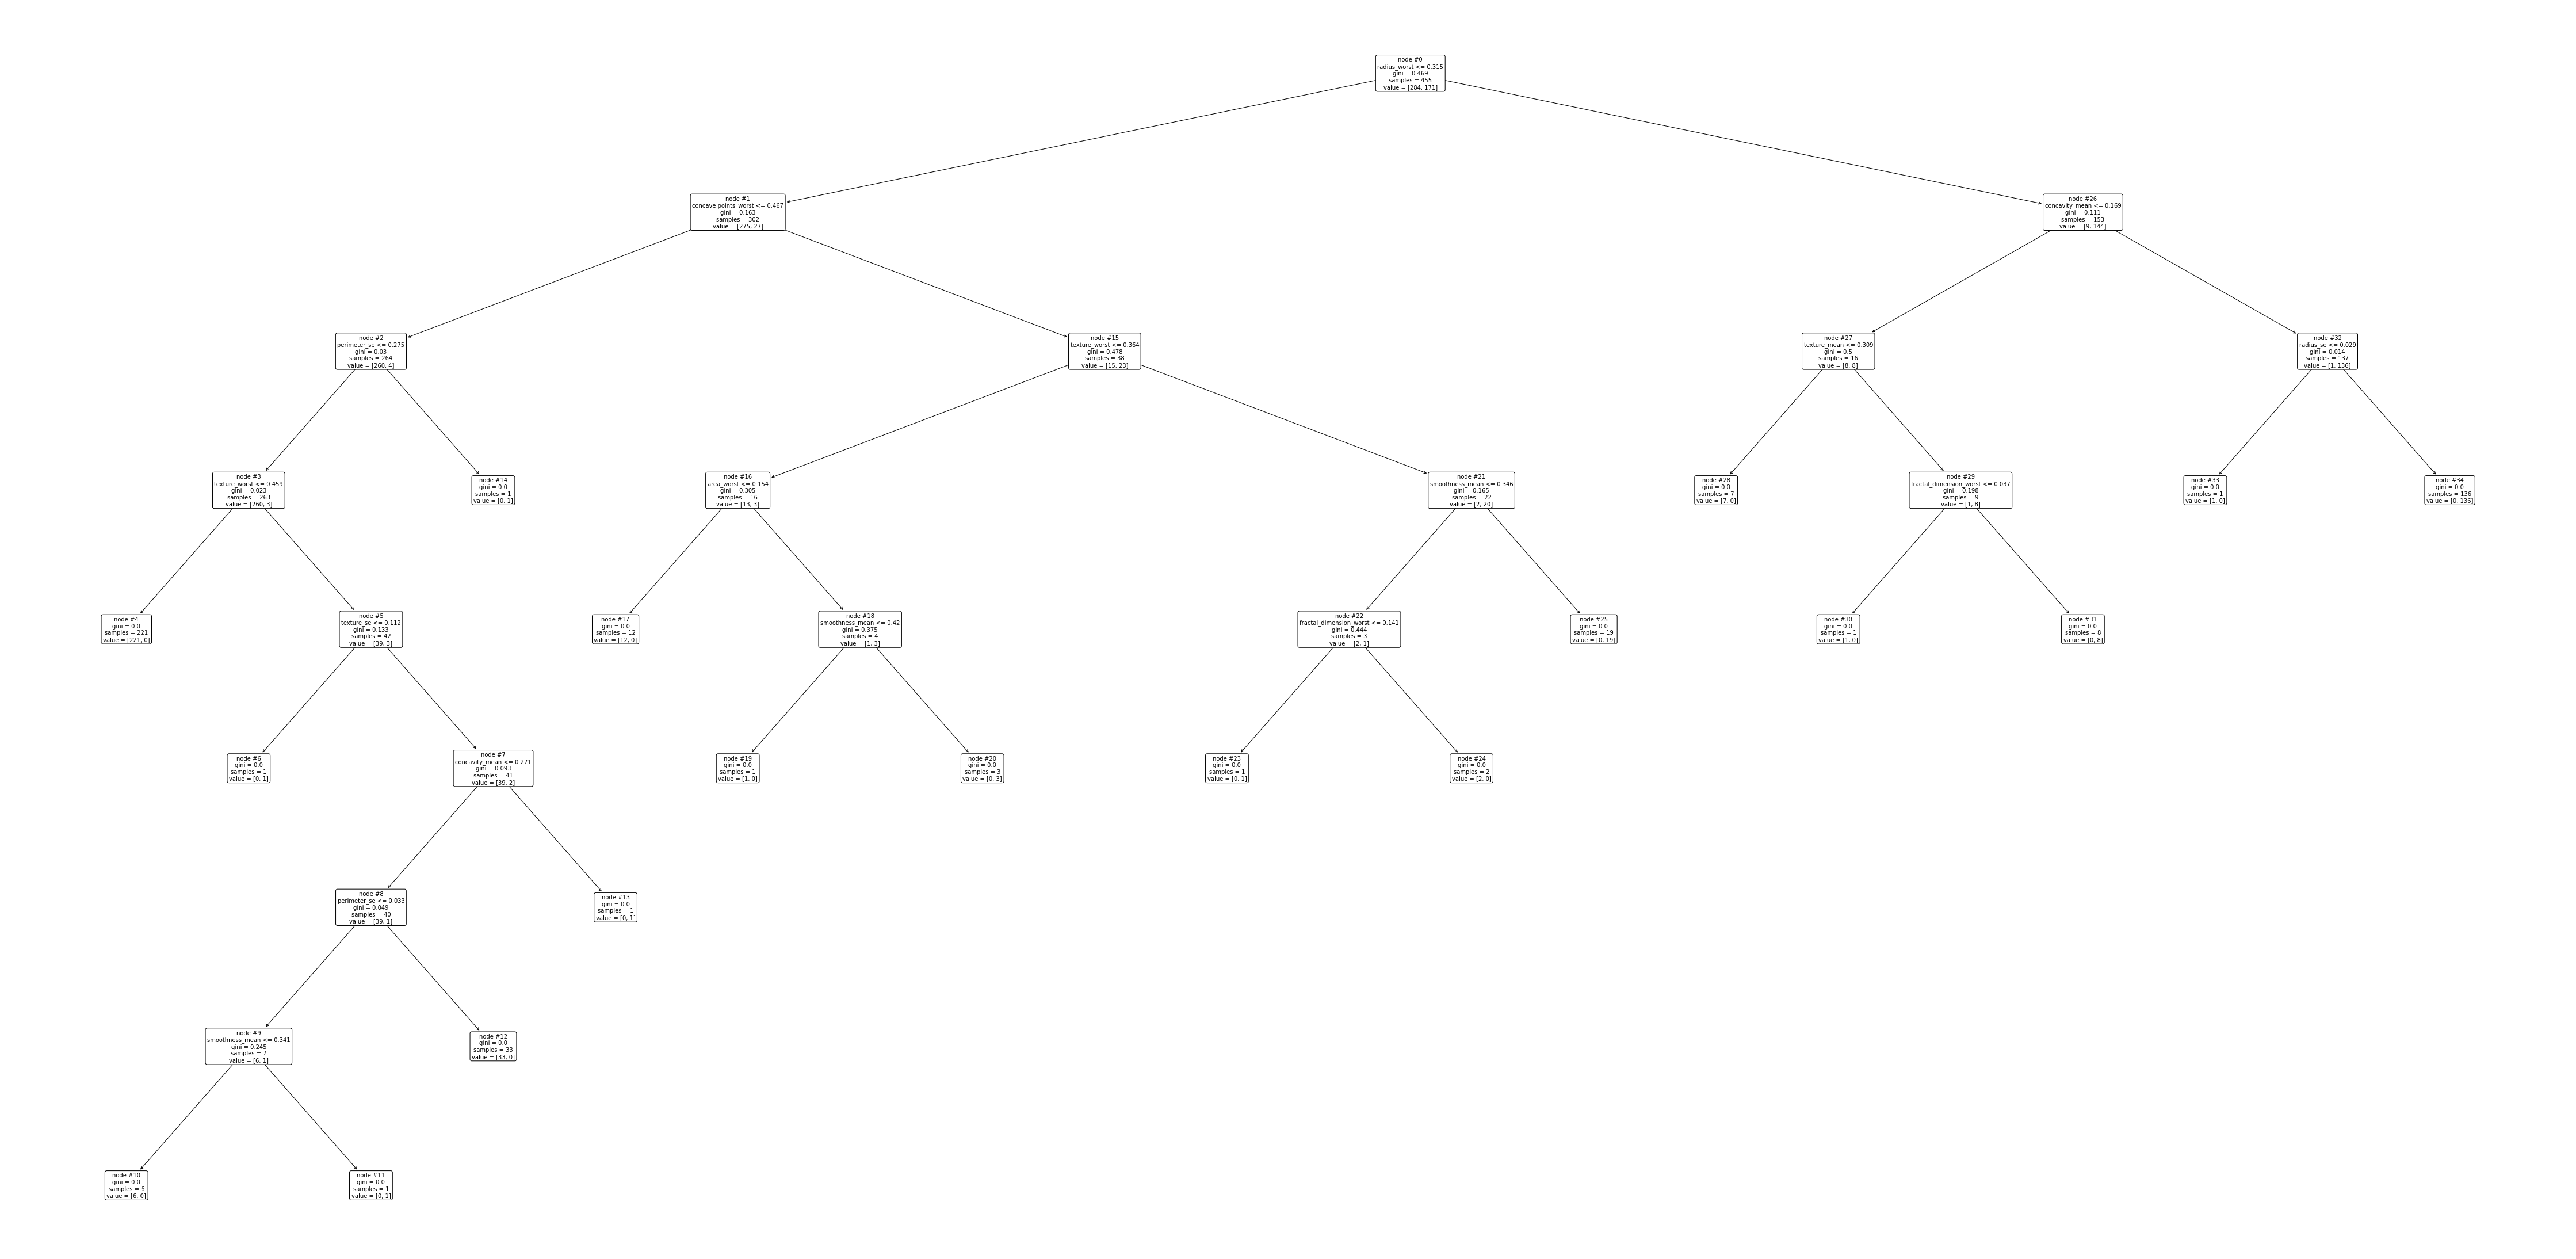

In [10]:
#### Plot the dt tree.
plt.figure(figsize=(80,40))
annotations = tree.plot_tree(models['dt'], fontsize=10, feature_names=df_info.ohe_feature_names, node_ids=True,rounded=True )
#If you need to colored the class >> filled=True

In [11]:
#### retrieve the input and cf vectors.

proto_input = input_and_cf['input'].loc[INDX]
proto_cf = input_and_cf['cf'].loc[INDX]

#### Present the decision path
tree_path = extract_decision_path(clf, graph, proto_input)
tree_path

[['<radius_worst &le; 0.315',
  'samples = 455',
  'value = [284, 171]',
  'class = N>'],
 ['<concavity_mean &le; 0.169',
  'samples = 153',
  'value = [9, 144]',
  'class = Y>'],
 ['<radius_se &le; 0.029', 'samples = 137', 'value = [1, 136]', 'class = Y>'],
 ['<gini = 0.0', 'value = [0, 136]', 'class = Y>']]

In [12]:
tree_path_cf = extract_decision_path(clf, graph, proto_cf)
tree_path_cf

[['<radius_worst &le; 0.315',
  'samples = 455',
  'value = [284, 171]',
  'class = N>'],
 ['<concavity_mean &le; 0.169',
  'samples = 153',
  'value = [9, 144]',
  'class = Y>'],
 ['<radius_se &le; 0.029', 'samples = 137', 'value = [1, 136]', 'class = Y>'],
 ['<gini = 0.0', 'value = [1, 0]', 'class = N>']]

In [13]:
# input_dp_img

In [14]:
# cf_dp_img

#### Get the histogram & pie chart.

In [15]:
#pretty tree
viz_dp_save_path = f"viz_decision_path_{alg_data_name}_idx_{INDX}"

tree_viz_args = {
    "tree_model": clf,
    "x_data": X_train,
    "y_data": y_train,
    "target_name": "target",
    "feature_names": df_info.ohe_feature_names,
    "class_names": list(class_names),
}


input_dp_viz = dtreeviz(
    **tree_viz_args,
    title=f"Decison Tree - {dataset_name} with decision path of Input",
    X=proto_input,
    show_just_path=False,
)

input_dp_viz.save(os.path.join(save_folder_path, f"{viz_dp_save_path}_input.svg"))

cf_dp_viz = dtreeviz(
    **tree_viz_args,
    title=f"Decison Tree - {dataset_name} with decision path of CF",
    X=proto_cf,
    show_just_path=False,
)

cf_dp_viz.save(os.path.join(save_folder_path, f"{viz_dp_save_path}_cf.svg"))


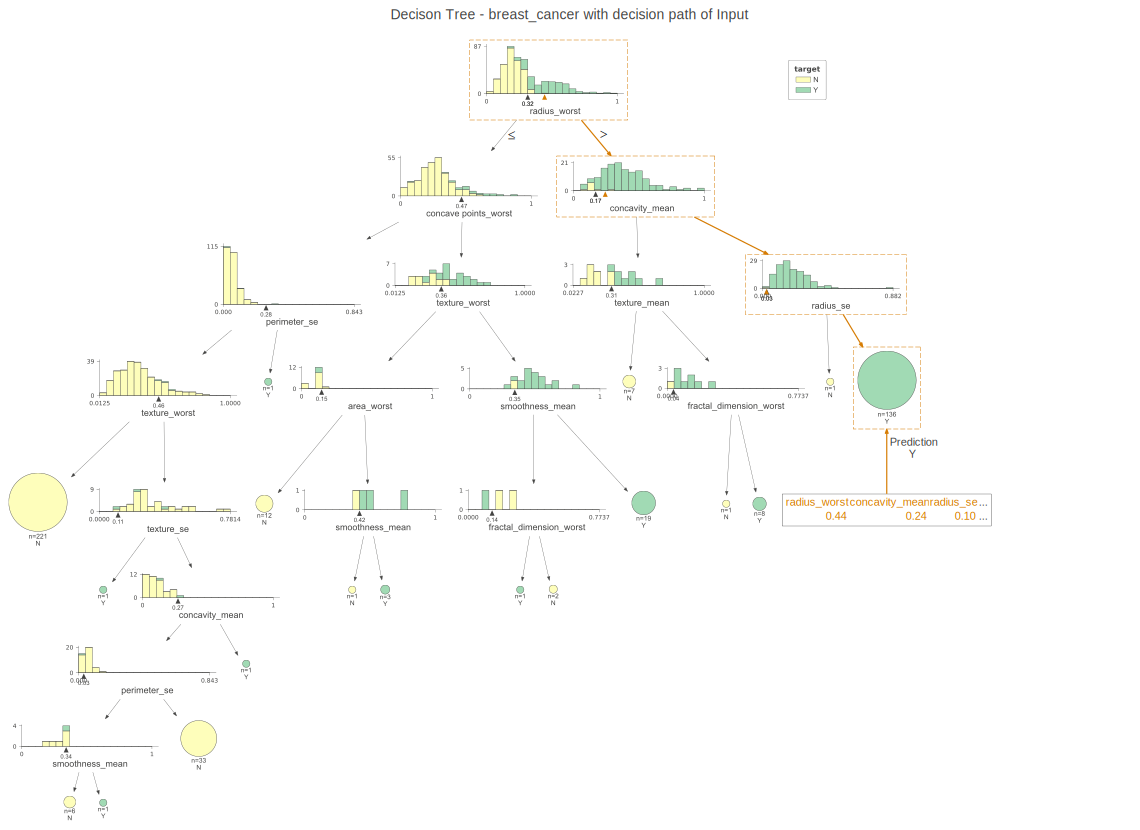

In [16]:
input_dp_viz

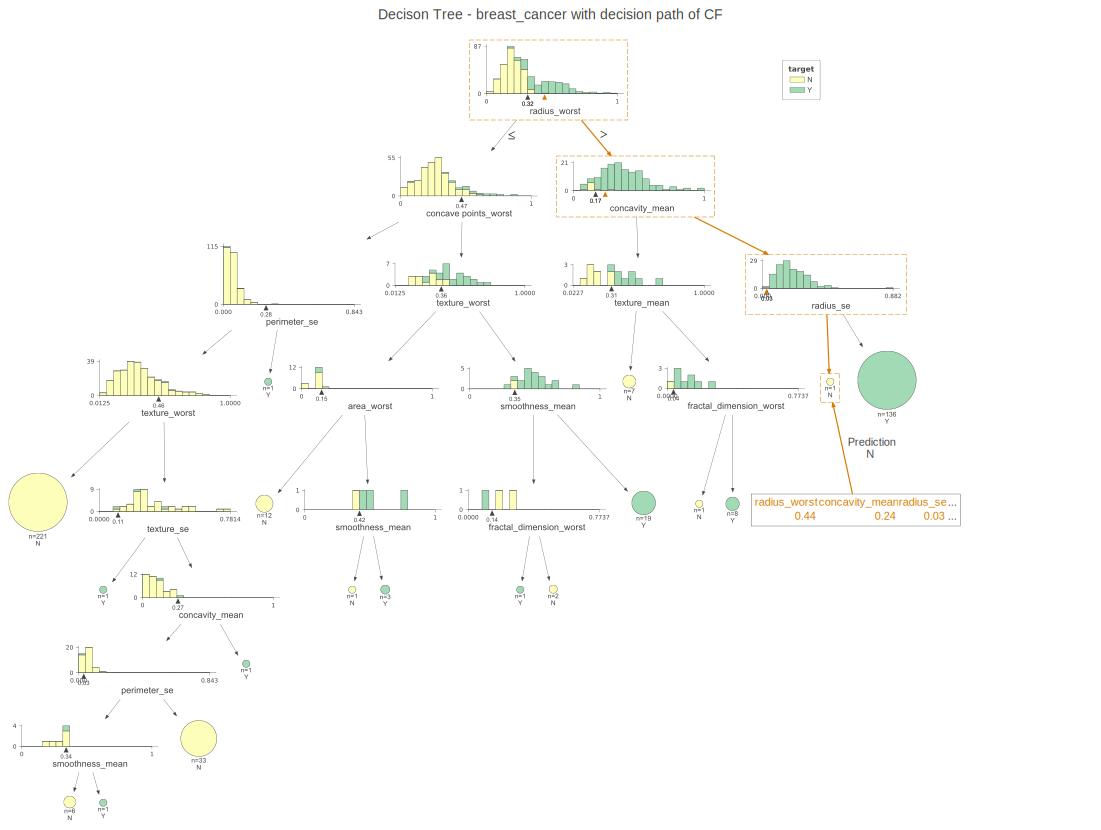

In [17]:
cf_dp_viz

In [18]:
viz_dp_jp_save_path = f"viz_decision_path_{alg_data_name}_idx_{INDX}_jp"

input_dp_jp_viz = dtreeviz(
    **tree_viz_args,
    title=f"Decison Tree - {dataset_name} with decision path of Input",
    X=proto_input,
    show_just_path=True,
)

input_dp_jp_viz.save(os.path.join(save_folder_path, f"{viz_dp_jp_save_path}_input.svg"))

cf_dp_jp_viz = dtreeviz(
    **tree_viz_args,
    title=f"Decison Tree - {dataset_name} with decision path of CF",
    X=proto_cf,
    show_just_path=True,
)

cf_dp_jp_viz.save(os.path.join(save_folder_path, f"{viz_dp_jp_save_path}_cf.svg"))


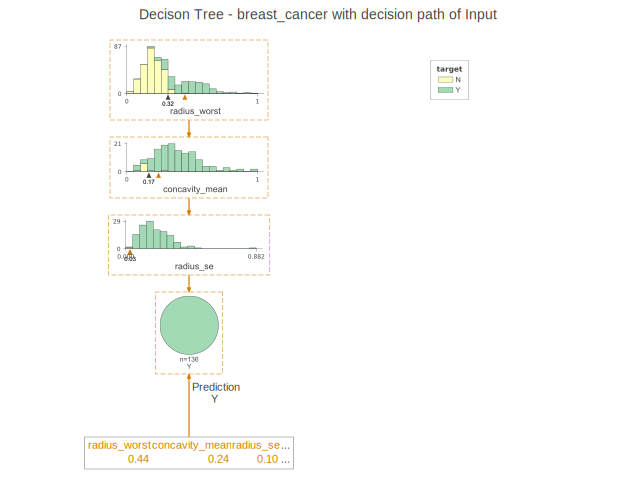

In [19]:
input_dp_jp_viz

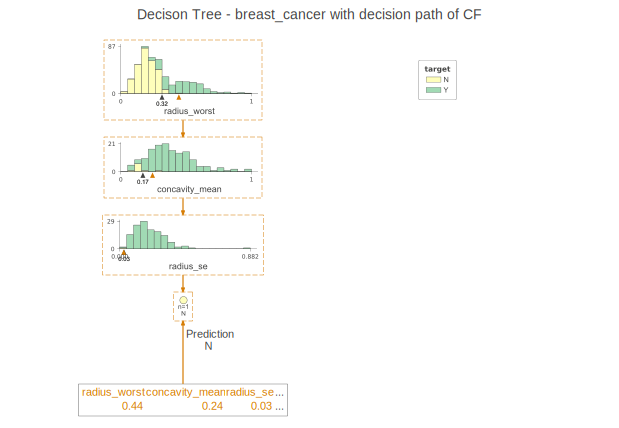

In [20]:
cf_dp_jp_viz